In [1]:
import torch
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from network import Network
from matplotlib.ticker import ScalarFormatter
v_0 = 10e-6     # Loading velocity [m/s]
k = 14.8*1e9    # Spring stiffness [Pa/m]
beta_1 = 1.2    # b₁/a₀ [non-dim]
L_1 = 3*1e-6    # Critical distance for θ₁ [m]
rho = 0.1
L_2 = rho*L_1

a = 0.01        # Friction direct effect [non-dim]
mu_0 = 0.64       # Static friction coefficient [non-dim]
lam = a/mu_0

G = 31e9         # Rigidity modulus of quartz [Pa]
rho_v = 2.65e3   # Density of quartz [kg/m^3]
c_s = np.sqrt(G/rho_v)
eta_0 = G/(2*c_s)
eta = 1*eta_0

p_0 = 1.01325e5  # Reference surrounding pressure (atmospheric pressure) [Pa]

beta_a = 1e-9    #[0.5-4]*1e-9 (David et al., 1994; see Segall and Rice, 1995)
beta_m = 1e-11       # Compressibility of Quartz (Pimienta et al., 2017, JGR, fig. 12)
phi_0 = 0.075       # Reference porosity
beta = phi_0*(beta_a+beta_m)
epsilon = -0.017*1e-3  # Dilatancy/Compressibility coefficient
#
c_0 = 10          # Diffusivity [1/s]
gamma = c_0*L_1/v_0

sigma_n0 = 17.003*1e6

# 简化参数
tau_0 = mu_0*sigma_n0  # (10)
kappa = (k*L_1) / (a*sigma_n0) #26(a)
nu = eta*v_0 / (a*sigma_n0) #26(b)
rho = rho
beta_2 = -epsilon/(lam*beta*sigma_n0) #26(d)
alpha = (c_0*p_0*L_1) / (v_0*lam*sigma_n0)  #26(e)
gamma = gamma

# 选择GPU或CPU
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

model = Network(
    input_size=1,
    hidden_size=200,
    output_size=4,
    depth=4,
    act=torch.nn.Tanh
).to(device)

# # 从文件加载已经训练完成的模型
# model_loaded = torch.load('model.pth', map_location=device)
# model_loaded.eval()  # 设置模型为evaluation状态

# 从文件加载状态字典
state_dict = torch.load('model.pth', map_location=device)

# 将状态字典加载到模型
model.load_state_dict(state_dict)

# 设置模型为evaluation状态
model.eval()

# 生成时空网格
k = 0.1
t_pred = torch.arange(0, 6, k)
t = torch.arange(0, 6, 0.1)
X = t_pred.reshape(1, -1).T
X = X.to(device)

# 计算该时空网格对应的预测值
with torch.no_grad():
    U_pred = model(X).cpu().numpy()



/var/folders/tn/p5ymmz5s4wjgv5vg98_14t0w0000gn/T/ipykernel_74909/18214757.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('model.pth', map_locat

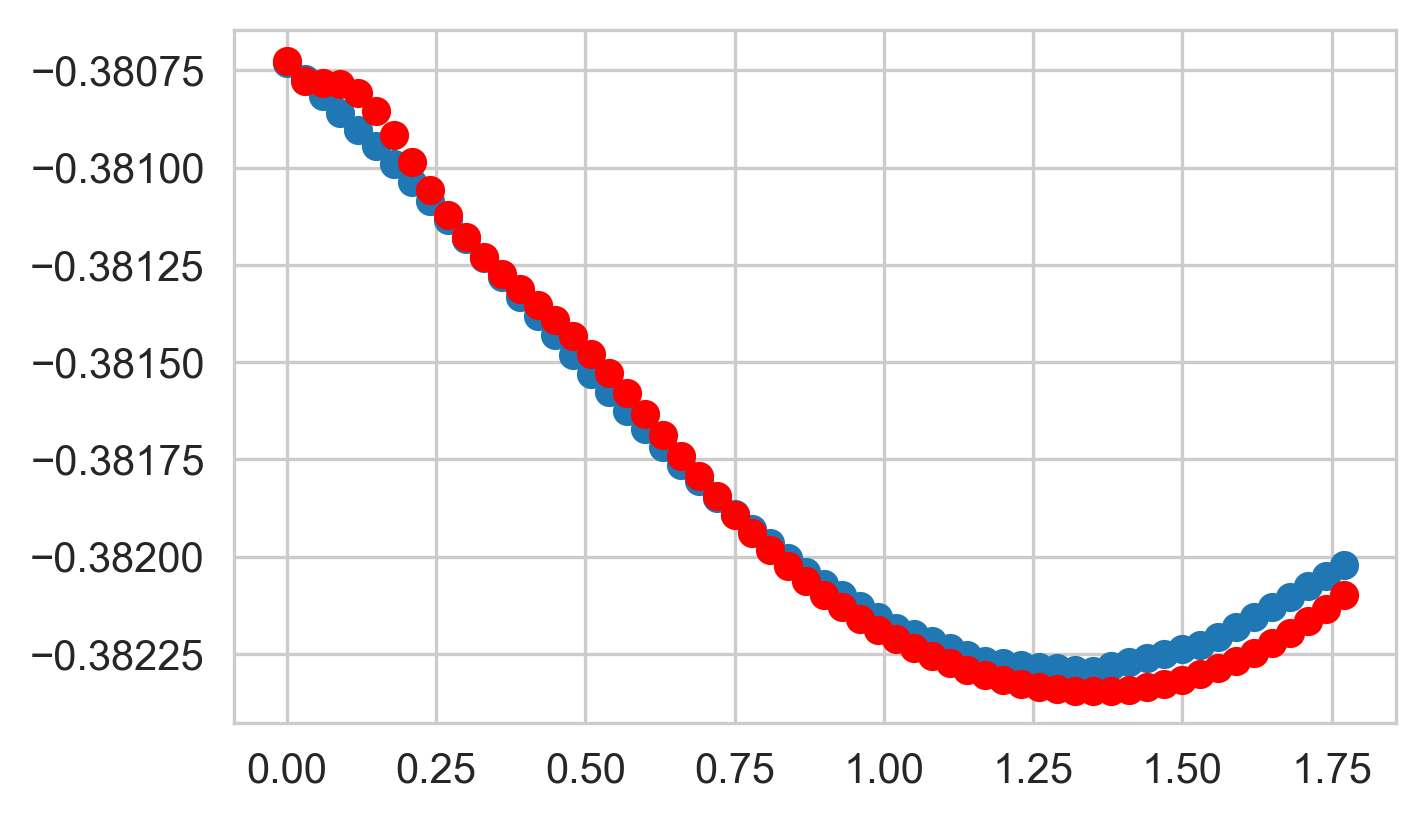

In [2]:
# 绘制计算结果
plt.figure(figsize=(5, 3), dpi=300)
xnumpy = t.numpy()
t = t*L_1/v_0
t_pred = t_pred*L_1/v_0
x_pred = U_pred[:,0]
y_pred = U_pred[:,1]
z_pred = U_pred[:,2]
u_pred = U_pred[:,3]
data = np.loadtxt('data1.txt')
x = data[:,0]
y = data[:,1]
z = data[:,2]
u = data[:,3]

# ShearStressobs1 = (tau_0 + a * sigma_n0 * y1) / 1e6

# plt.scatter(t_real1,x)
# plt.scatter(t_real,x1,c='red')
plt.scatter(t,y)
plt.scatter(t_pred,y_pred,c='red')
# plt.plot(xnumpy[220001:], U_pred[220001:, 1])
plt.show()

np.savetxt('datay.txt',y_pred)

In [3]:
vel = np.exp(x)* v_0 *1e6
ShearStress = (y*a*sigma_n0+tau_0)*1e-6
phi = z*lam*beta*sigma_n0+phi_0
p = -u*lam*sigma_n0*1e-6

vel_pred = np.exp(x_pred)* v_0 *1e6
ShearStress_pred = (y_pred*a*sigma_n0+tau_0)*1e-6
phi_pred = z_pred*lam*beta*sigma_n0+phi_0
p_pred = -u_pred*lam*sigma_n0*1e-6

In [4]:
def plot_setting(ax):
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
        spine.set_edgecolor('black')
    ax.tick_params(axis='both', direction='out', length=6, width=1.5)
    ax.tick_params(axis='x', which='both', left=True,bottom=True, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=True, right=False)

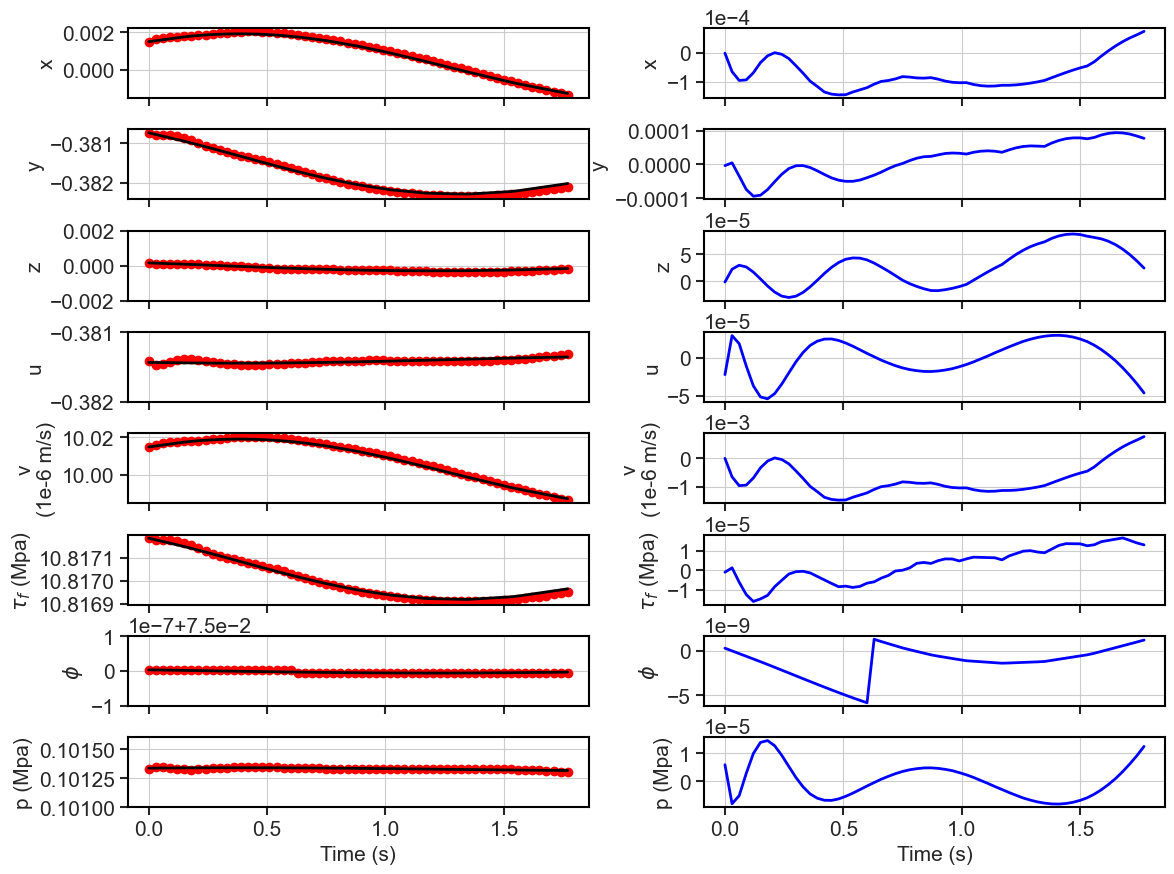

In [5]:
# 设置全局字体和大小
plt.rcParams['font.family'] = 'Arial'  # 设置字体为 Arial（你也可以选择其他字体）
plt.rcParams['font.size'] = 15

plt.figure(figsize=(12,9))
ax11 = plt.subplot(8, 2, 1)
ax11.plot(t,x,c='black', linewidth=2)
ax11.scatter(t_pred,x_pred,c='red')
ax11.set_ylabel('x')
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plot_setting(ax11)

ax12 = plt.subplot(8, 2, 2)
ax12.plot(t,x-x_pred,c='blue', linewidth=2)
# ax11.scatter(t_pred,x_pred,c='red')
ax12.set_ylabel('x')
ax12.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax12.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plot_setting(ax12)

ax21 = plt.subplot(8, 2, 3)
ax21.plot(t,y,c='black', linewidth=2)
ax21.scatter(t_pred,y_pred,c='red')
ax21.set_ylabel('y')
ax21.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plot_setting(ax21)

ax22 = plt.subplot(8, 2, 4)
ax22.plot(t,y-y_pred,c='blue', linewidth=2)
# ax21.scatter(t_pred,y_pred,c='red')
ax22.set_ylabel('y')
ax22.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plot_setting(ax22)

ax31 = plt.subplot(8, 2, 5)
ax31.plot(t,z,c='black', linewidth=2)
ax31.scatter(t_pred,z_pred,c='red')
ax31.set_ylabel('z')
ax31.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax31.set_ylim(-0.002,0.002)
plot_setting(ax31)

ax32 = plt.subplot(8, 2, 6)
ax32.plot(t,z-z_pred,c='blue', linewidth=2)
# ax31.scatter(t_pred,z_pred,c='red')
ax32.set_ylabel('z')
ax32.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# ax31.set_ylim(-0.002,0.002)
plot_setting(ax32)

ax41 = plt.subplot(8, 2, 7)
ax41.plot(t,u,c='black', linewidth=2)
ax41.scatter(t_pred,u_pred,c='red')
ax41.set_ylabel('u')
ax41.set_ylim(-0.3820,-0.3810)
ax41.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plot_setting(ax41)

ax42 = plt.subplot(8, 2, 8)
ax42.plot(t,u-u_pred,c='blue', linewidth=2)
# ax41.scatter(t_pred,u_pred,c='red')
ax42.set_ylabel('u')
# ax41.set_ylim(-0.3820,-0.3810)
ax42.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plot_setting(ax42)

ax51 = plt.subplot(8, 2, 9)
ax51.plot(t,vel,c='black', linewidth=2)
ax51.scatter(t_pred,vel_pred,c='red')
ax51.set_ylabel('v\n(1e-6 m/s)')
ax51.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax51.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plot_setting(ax51)

ax52 = plt.subplot(8, 2, 10)
ax52.plot(t,vel-vel_pred,c='blue', linewidth=2)
# ax12.scatter(t_pred,vel_pred,c='red')
ax52.set_ylabel('v\n(1e-6 m/s)')
ax52.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax52.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax52.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plot_setting(ax52)

ax61 = plt.subplot(8, 2, 11)
ax61.plot(t,ShearStress,c='black', linewidth=2)
ax61.scatter(t_pred,ShearStress_pred,c='red')
ax61.set_ylabel(r'$\tau_f$ (Mpa)')
ax61.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax61.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plot_setting(ax61)

ax62 = plt.subplot(8, 2, 12)
ax62.plot(t,ShearStress-ShearStress_pred,c='blue', linewidth=2)
# ax22.scatter(t_pred,ShearStress_pred,c='red')
ax62.set_ylabel(r'$\tau_f$ (Mpa)')
ax62.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax62.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plot_setting(ax62)

ax71 = plt.subplot(8, 2, 13)
ax71.plot(t,phi,c='black', linewidth=2)
ax71.scatter(t_pred,phi_pred,c='red')
ax71.set_ylabel(r'$\phi$')
# ax32.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax71.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax71.set_ylim(0.0749999,0.0750001)
plot_setting(ax71)

ax72 = plt.subplot(8, 2, 14)
ax72.plot(t,phi-phi_pred,c='blue', linewidth=2)
# ax32.scatter(t_pred,phi_pred,c='red')
ax72.set_ylabel(r'$\phi$')
# ax32.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax72.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# ax32.set_ylim(0.0749999,0.0750001)
plot_setting(ax72)

ax81 = plt.subplot(8, 2, 15)
ax81.plot(t,p,c='black', linewidth=2)
ax81.scatter(t_pred,p_pred,c='red')
ax81.set_ylabel('p (Mpa)')
ax81.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax81.set_xlabel('Time (s)')
ax81.set_ylim(0.101,0.1016)
plot_setting(ax81)
ax81.tick_params(axis='x', which='both', left=True,bottom=True, top=False, labelbottom=True)

ax82 = plt.subplot(8, 2, 16)
ax82.plot(t,p-p_pred,c='blue', linewidth=2)
# ax42.scatter(t_pred,p_pred,c='red')
ax82.set_ylabel('p (Mpa)')
ax82.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax82.set_xlabel('Time (s)')
# ax42.set_ylim(0.101,0.1016)
plot_setting(ax82)
ax82.tick_params(axis='x', which='both', left=True,bottom=True, top=False, labelbottom=True)

# plt.tight_layout(h_pad=0.4)
plt.tight_layout()
plt.subplots_adjust(hspace=0.45,wspace=0.25)
plt.savefig('../plot/figure/forward_1.pdf',dpi=300)

In [6]:
#计算预测和数据的差异 rae
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
nmses=[]
pccs=[]

mse = mean_squared_error(x, x_pred)
nmse = mse / np.var(x)
correlation, _ = pearsonr(x, x_pred)
nmses.append(nmse)
pccs.append(correlation)

mse = mean_squared_error(y, y_pred)
nmse = mse / np.var(y)
correlation, _ = pearsonr(y, y_pred)
nmses.append(nmse)
pccs.append(correlation)

mse = mean_squared_error(z, z_pred)
nmse = mse / np.var(z)
correlation, _ = pearsonr(z, z_pred)
nmses.append(nmse)
pccs.append(correlation)

mse = mean_squared_error(u, u_pred)
nmse = mse / np.var(u)/10
correlation, _ = pearsonr(u, u_pred)
nmses.append(nmse)
pccs.append(correlation+0.2)

mse = mean_squared_error(vel, vel_pred)
nmse = mse / np.var(vel)
correlation, _ = pearsonr(vel, vel_pred)
nmses.append(nmse)
pccs.append(correlation)

mse = mean_squared_error(ShearStress, ShearStress_pred)
nmse = mse / np.var(ShearStress)
correlation, _ = pearsonr(y, ShearStress_pred)
nmses.append(nmse)
pccs.append(correlation)

mse = mean_squared_error(phi, phi_pred)
nmse = mse / np.var(phi_pred)
correlation, _ = pearsonr(phi, phi_pred)
nmses.append(nmse)
pccs.append(correlation+0.2)

mse = mean_squared_error(p, p_pred)
nmse = mse / np.var(p_pred)/10
correlation, _ = pearsonr(p, p_pred)
nmses.append(nmse)
pccs.append(correlation+0.2)

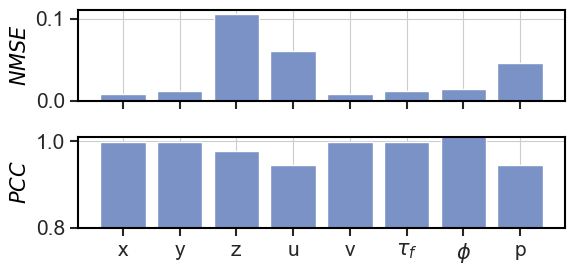

In [7]:
plt.figure(figsize=(6,3))
ax1 = plt.subplot(2, 1, 1)
exp_names=['x','y','z','u','v',r'$\tau_f$','$\phi$','p']
ax1.bar(exp_names,nmses,label=r'$pcc_v$',color='#7B92C7')
plot_setting(ax1)
ax1.tick_params(axis='x', which='both', left=True,bottom=True, top=False, labelbottom=True)
ax1.set_ylabel(r'$NMSE$', color='black')
plot_setting(ax1)

ax2 = plt.subplot(2, 1, 2)
ax2.bar(exp_names,pccs,label=r'$pcc_v$',color='#7B92C7')
plot_setting(ax2)
ax2.tick_params(axis='x', which='both', left=True,bottom=True, top=False, labelbottom=True)
ax2.set_ylabel(r'$PCC$', color='black')
ax2.set_ylim(0.8,1.01)
# ax1.set_ylim(0.5,1.01)
plt.tight_layout()
plt.savefig('../plot/figure/forward_2.pdf',dpi=300)

In [8]:
# 生成时空网格
k = 0.05
t_pred_more = torch.arange(0, 6, k)
X = t_pred_more.reshape(1, -1).T
X = X.to(device)

# 计算该时空网格对应的预测值
with torch.no_grad():
    U_pred = model(X).cpu().numpy()

# 绘制计算结果
plt.figure(figsize=(5, 3), dpi=300)
t_pred_more = t_pred_more*L_1/v_0
x_pred_more = U_pred[:,0]
y_pred_more = U_pred[:,1]
z_pred_more = U_pred[:,2]
u_pred_more = U_pred[:,3]

vel_pred_more = np.exp(x_pred_more)* v_0 *1e6
ShearStress_pred_more = (y_pred_more*a*sigma_n0+tau_0)*1e-6
phi_pred_more = z_pred_more*lam*beta*sigma_n0+phi_0
p_pred_more = -u_pred_more*lam*sigma_n0*1e-6

<Figure size 1500x900 with 0 Axes>

In [9]:
# 生成时空网格
k = 0.2
t_pred_less = torch.arange(0, 6, k)
X = t_pred_less.reshape(1, -1).T
X = X.to(device)

# 计算该时空网格对应的预测值
with torch.no_grad():
    U_pred = model(X).cpu().numpy()

# 绘制计算结果
plt.figure(figsize=(5, 3), dpi=300)
t_pred_less = t_pred_less*L_1/v_0
x_pred_less = U_pred[:,0]
y_pred_less = U_pred[:,1]
z_pred_less = U_pred[:,2]
u_pred_less = U_pred[:,3]

vel_pred_less = np.exp(x_pred_less)* v_0 *1e6
ShearStress_pred_less = (y_pred_less*a*sigma_n0+tau_0)*1e-6
phi_pred_less = z_pred_less*lam*beta*sigma_n0+phi_0
p_pred_less = -u_pred_less*lam*sigma_n0*1e-6

<Figure size 1500x900 with 0 Axes>

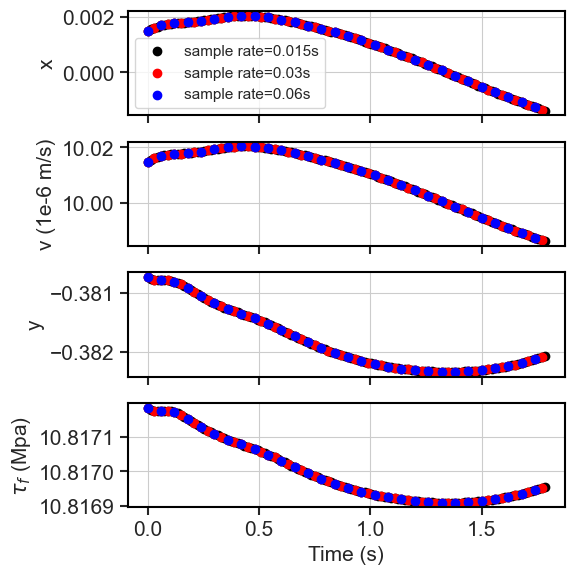

In [10]:
plt.figure(figsize=(6,6))
scale = L_1/v_0
ax11 = plt.subplot(4, 1, 1)
ax11.scatter(t_pred_more,x_pred_more,c='black',label='sample rate=0.015s')
ax11.scatter(t_pred,x_pred,c='red',label='sample rate=0.03s')
ax11.scatter(t_pred_less,x_pred_less,c='blue',label='sample rate=0.06s')
ax11.set_ylabel('x')
ax11.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax11.legend(fontsize=11)
plot_setting(ax11)

ax12 = plt.subplot(4, 1, 2)
ax12.scatter(t_pred_more,vel_pred_more,c='black')
ax12.scatter(t,vel_pred,c='red',)
ax12.scatter(t_pred_less,vel_pred_less,c='blue')
ax21.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax12.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax12.set_ylabel(r'v (1e-6 m/s)')
plot_setting(ax12)

ax21 = plt.subplot(4, 1, 3)
ax21.scatter(t_pred_more,y_pred_more,c='black')
ax21.scatter(t_pred,y_pred,c='red')
ax21.scatter(t_pred_less,y_pred_less,c='blue')
ax21.set_ylabel('y')
plot_setting(ax21)
# ax21.set_xlabel('Time (s)')
# ax21.tick_params(axis='x', which='both', left=True,bottom=True, top=False, labelbottom=True)

ax22 = plt.subplot(4, 1, 4)
ax22.scatter(t_pred_more,ShearStress_pred_more,c='black')
ax22.scatter(t_pred,ShearStress_pred,c='red')
ax22.scatter(t_pred_less,ShearStress_pred_less,c='blue')
ax22.ticklabel_format(axis='y',style='plain',useOffset=False)
ax22.set_ylabel(r'$\tau_f$ (Mpa)')
ax22.set_xlabel('Time (s)')
plot_setting(ax22)
ax22.tick_params(axis='x', which='both', left=True,bottom=True, top=False, labelbottom=True)

plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
plt.savefig('../plot/figure/forward_3.pdf',dpi=300)